<a href="https://colab.research.google.com/github/sureshnaidugolla/myrepo/blob/GP/basic_Aquisition_function_test_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import stuff

because gpCAM requires an older version of numpy, be sure to restart the notebook after initial installation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP
except:
    !pip install gpcam==8.0.2
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP

try:
    import torch
except:
    !pip install torch
    import torch

### import custom module !! might be modified in the future !!
try:
    from gpcam_test_instrument import gpcam_test_instrument
except:
    !wget https://github.com/jcandane/StochasticPhysics/raw/main/gpcam_test_instrument.py
    from gpcam_test_instrument import gpcam_test_instrument

### import Noack's file on example kernels
try:
    from kernel_function import kernel_l2_single_task, kernel_l2_multi_task, kernel_l1, fvgp_kernel, non_stat_kernel_2d, symmetric_kernel, symmetric_kernel2, periodic_kernel_2d
except:
    !wget https://raw.githubusercontent.com/lbl-camera/gpCAM/master/examples/kernel_function.py
    from kernel_function import kernel_l2_single_task, kernel_l2_multi_task, kernel_l1, fvgp_kernel, non_stat_kernel_2d, symmetric_kernel, symmetric_kernel2, periodic_kernel_2d

--2024-03-05 16:59:51--  https://github.com/jcandane/StochasticPhysics/raw/main/gpcam_test_instrument.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jcandane/StochasticPhysics/main/gpcam_test_instrument.py [following]
--2024-03-05 16:59:51--  https://raw.githubusercontent.com/jcandane/StochasticPhysics/main/gpcam_test_instrument.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6882 (6.7K) [text/plain]
Saving to: ‘gpcam_test_instrument.py’

gpcam_test_instrume 100%[===================>]   6.72K  --.-KB/s    in 0s      

2024-03-05 16:59:51 (74.1 MB/s) - ‘gpcam_test_instrument.py’ saved [688

# Lists

## Acquisition functions used

from https://gpcam.lbl.gov/examples/acquisition-functions

In [2]:

#available 12 acquisition functions:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

## Kernel functions

In [3]:
kernel_functions = [ kernel_l2_single_task,
                     kernel_l2_multi_task, kernel_l1, fvgp_kernel, non_stat_kernel_2d, ### these dont work at least for single-task problems
                     symmetric_kernel, symmetric_kernel2, periodic_kernel_2d ] ## : List[ Callable ]

kernel_functions = [ kernel_l2_single_task,
                     symmetric_kernel, symmetric_kernel2, periodic_kernel_2d, periodic_kernel_2d ] ## : List[ Callable ]

## ("Instrument") Functions used

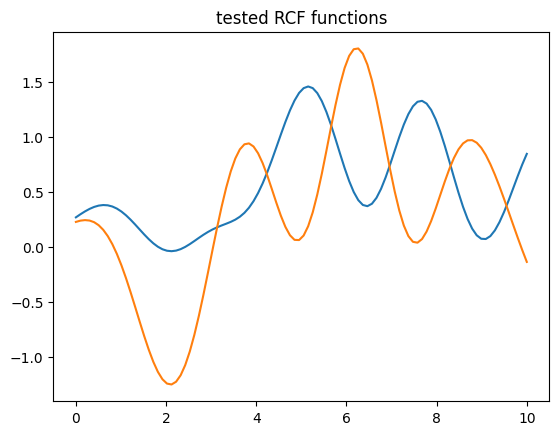

In [4]:
input_space         = np.array([[ 0.0, 10.0]])
number_of_functions = 2

apparatuses = [ gpcam_test_instrument(input_space, 12, D=1, ξ=2) for i in range(number_of_functions) ]

xs = np.linspace(input_space[0,0], input_space[0,1], 100)
ys = np.asarray([ f.rcf.evalulate(xs.reshape(-1,1)).reshape(-1) for f in apparatuses ]).T

plt.plot(xs, ys)
plt.title("tested RCF functions")
plt.show()

# Prototyping space

In [5]:
f = apparatuses[0]
k = kernel_functions

my_experiment = AutonomousExperimenterFvGP(f.domain,
                                           f.D, 1,
                                           init_dataset_size=10,
                                           instrument_function=f.test_instrumentt,
                                           kernel_function = k[2],
                                           acquisition_function="variance")
my_experiment.train()
my_experiment.go(10)



/usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:300: UserWarning: You have provided callables for kernel, mean, or noise                 functions but no initial hyperparameters.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:300: UserWarning: It is likely they have to be defined for a success initialization.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:300: UserWarning: No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
  super().__init__(


# Test Space

runs in about 6m

## julio's plot

In [ ]:
data_out=[]
for f in apparatuses:
    acq_data_out=[]
    for kernel_function in kernel_functions:
          my_experiment = AutonomousExperimenterFvGP(f.domain,
                                                      f.D, 1,
                                                      init_dataset_size=10,
                                                      instrument_function=f.test_instrumentt,
                                                      kernel_function=kernel_function,
                                                      acquisition_function="variance")
          my_experiment.train()
          my_experiment.go(10)
          acq_data_out.append( np.asarray([ my_experiment.x_data.flatten(), my_experiment.y_data.flatten() ]) )
    data_out.append(acq_data_out)

data_out = np.asarray( data_out )
data_out.shape ## (instruments, acquisition-functions, coordinate, data-points)


############## Plotting
fig, axs = plt.subplots(data_out.shape[0],data_out.shape[1])
for a in range(len(apparatuses)):
    for k in range(len(kernel_functions)):
          axs[a,k].scatter(data_out[a, k, 0], data_out[a,k,1])
          axs[a,k].plot(xs, ys[:,a])
          axs[a,k].label(k)

plt.show()

note acquisition-function should be in .go() class-function because it is only at this point we require the function!